In [98]:
import pandas as pd
import numpy as np
from functools import cmp_to_key
from datetime import datetime

def combine_reviews(award_reviews: pd.DataFrame, non_award_reviews: pd.DataFrame) -> pd.DataFrame:
    # set a stable MultiIndex on (user_id, username); drop the 2 meta columns from data
    aw = award_reviews.set_index(list(award_reviews.columns[:1]))
    naw = non_award_reviews.set_index(list(non_award_reviews.columns[:1]))

    # align to the union of users
    idx = aw.index.union(naw.index)
    aw, naw = aw.reindex(idx), naw.reindex(idx)

    # combined z-score matrix: rows = users, cols = all movies (winners + non-winners)
    return pd.concat([aw, naw], axis=1)


def user_intersection(df_1, df_2):
    user_col = 'username'
    common = set(df_1[user_col]) & set(df_2[user_col])

    a = (df_1[df_1[user_col].isin(common)]
         .sort_values(user_col)
         .drop_duplicates(subset=[user_col], keep="first")
         .reset_index(drop=True))
    b = (df_2[df_2[user_col].isin(common)]
         .sort_values(user_col)
         .drop_duplicates(subset=[user_col], keep="first")
         .reset_index(drop=True))

    a.insert(0, "user_id", range(len(a)))
    b.insert(0, "user_id", range(len(b)))

    assert len(a) == len(b), "still mismatched — check for NaNs or types"
    return a, b

def sanatize(df):
    cols = df.columns.difference(['username'])
    df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')




def compare_movies(a: str, b: str, null_last: bool = True) -> int:
    """Return -1 if a<b, 0 if equal, +1 if a>b by release date.
       Movies with missing dates go last if null_last=True."""
    da = movies.at[a, 'date']
    db = movies.at[b, 'date']
    fmt = "%m/%d/%Y"
    d1 = datetime.strptime(da, fmt).date()
    d2 = datetime.strptime(db, fmt).date()
    return (d1 > d2) - (d1 < d2)


award_reviews = pd.read_csv('user_award_reviews.csv')
non_award_reviews = pd.read_csv('user_non_award_reviews.csv')

award_reviews, non_award_reviews = user_intersection(award_reviews, non_award_reviews)
df = combine_reviews(award_reviews, non_award_reviews)
df.drop(columns=['username'], inplace=True)
sanatize(df)


award_movie_date = pd.read_csv('awarded_movie_date.csv')
non_award_movie_date = pd.read_csv('non_awarded_movie_date.csv')
movies = pd.concat([award_movie_date, non_award_movie_date])
movies.set_index('movie', inplace=True)


#sort columns
# populated_frac = df.notna().mean()
# order = populated_frac.sort_values(ascending=False).index
# df = df[order]

#sort rows
# pop_rows = df.notna().mean(axis=1)
# row_order = pop_rows.sort_values(ascending=False, kind="mergesort").index
# df = df.loc[row_order]

ordered_cols = sorted(df.columns, key=cmp_to_key(compare_movies))
df = df[ordered_cols]
    

print(f'Top five most rated: {list(df.columns[0:5])}')
print(f'Bottom five most rated: {list(df.columns[-5:])}')

Top five most rated: ['boyhood', 'the-grand-budapest-hotel', 'birdman-or-the-unexpected-virtue-of-ignorance', 'the-imitation-game', 'star-wars-the-force-awakens']
Bottom five most rated: ['anora', 'nickel-boys', 'conclave', 'maria-2024', 'wicked-2024']


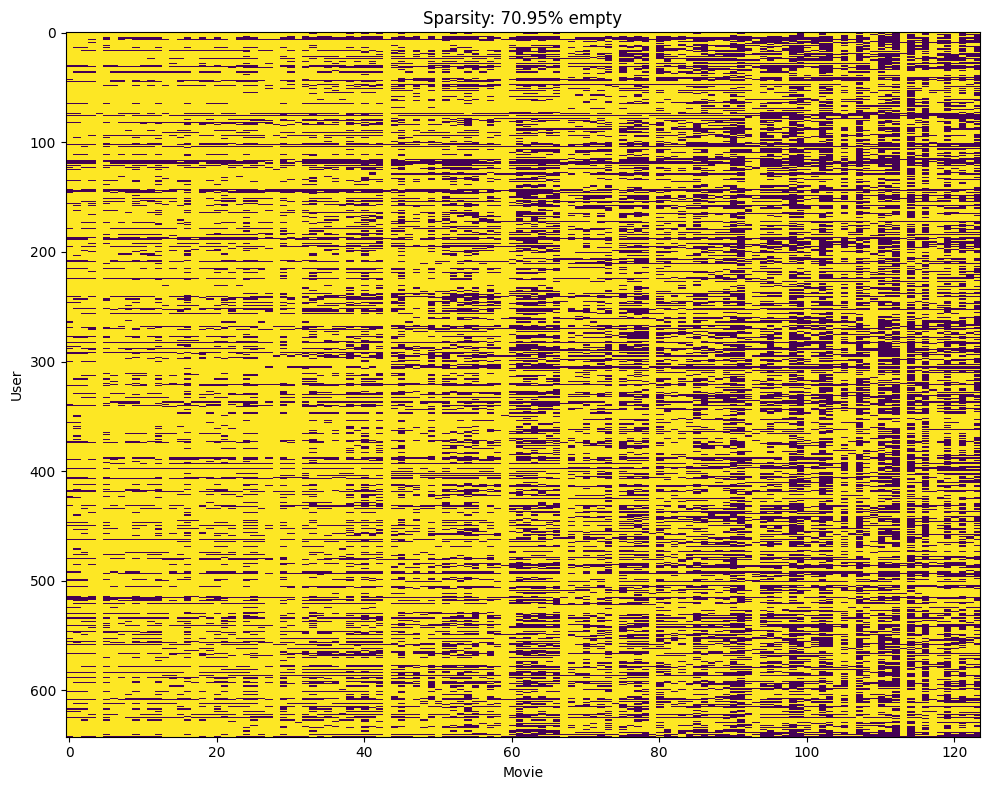

In [106]:
import numpy as np
import matplotlib.pyplot as plt


mask = df.isna().to_numpy()
plt.figure(figsize=(10, 8))
plt.imshow(mask, aspect="auto", interpolation="nearest")
plt.xlabel("Movie"); plt.ylabel("User")
plt.title("Sparsity: 70.95% empty")
plt.tight_layout(); plt.show()


In [102]:
sparsity_pct = df.isna().to_numpy().mean() * 100

In [103]:
sparsity_pct

np.float64(70.95143731500528)